# Sentiment Analysis with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

## Application of Hugging Face Text classification model Fune-tuning

In [ ]:
pip install huggingface_hub["fastai"]

In [ ]:
pip install transformers[torch]

In [ ]:
!pip install datasets

In [ ]:
# loading modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from fastai.text import *
import warnings
import wordcloud as wc

In [ ]:
import os
import pandas as pd
from datasets import load_dataset
from sklearn.model_selection import train_test_split

In [ ]:
# Disabe W&B
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
# Load the dataset and display some values
df = pd.read_csv('Train.csv')

# A way to eliminate rows containing NaN values
df = df[~df.isna().any(axis=1)]


# **Exploratory Data Analysis**

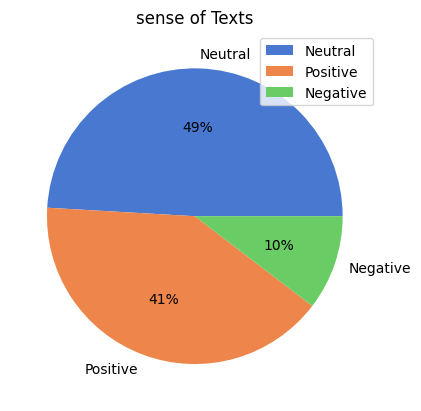

<Figure size 1000x500 with 0 Axes>

In [ ]:
# Define the data and labels for the pie chart
data = df["label"].value_counts()
labels = ['Neutral', 'Positive', 'Negative']

# Choose a Seaborn color palette
colors = sns.color_palette('muted')

# Create the pie chart with Matplotlib
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')

# Add a title and a legend to the pie chart
plt.title('sense of Texts')
plt.legend(loc='upper right')

# Adjusting size
plt.figure(figsize=(10, 5))

# Show the pie chart
plt.show()

In [ ]:
data = df
data["agreement"] = df["agreement"].round(2)

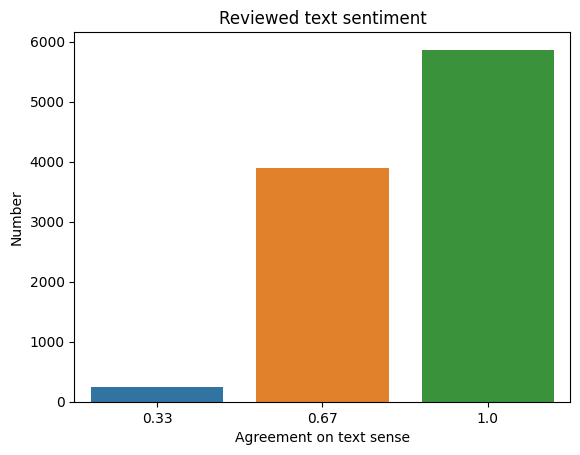

In [ ]:
# Create a bar chart with Seaborn
sns.countplot(x="agreement", data=data)

# Add labels and title to the chart
plt.xlabel("Agreement on text sense")
plt.ylabel("Number")
plt.title("Reviewed text sentiment")

# Show the chart
plt.show()

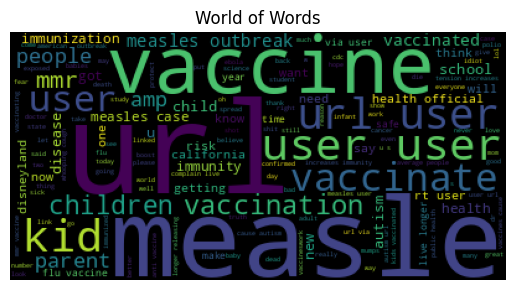

In [ ]:
# Extract the texts column as a Series object
texts = data['safe_text']

# Convert the texts to lowercase and join them into a single string
text = texts.str.lower().str.cat(sep=' ')

# Create a word cloud object with the WordCloud() function and pass in the text
cloud = wc.WordCloud().generate(text)

# Display the word cloud with matplotlib using the imshow() and show() functions
plt.imshow(cloud)
plt.axis('off')
plt.title("World of Words")
plt.show()

In [ ]:
# Split the train data => {train, eval}
train, eval = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
train.head()

,tweet_id,safe_text,label,agreement
9305,YMRMEDME,Mickey's Measles has gone international <url>,0.0,1.00
3907,5GV8NEZS,S1256 [NEW] Extends exemption from charitable ...,0.0,1.00
795,EI10PS46,<user> your ignorance on vaccines isn't just ...,1.0,0.67
5793,OM26E6DG,Pakistan partly suspends polio vaccination pro...,0.0,1.00
3431,NBBY86FX,In other news I've gone up like 1000 mmr,0.0,1.00


In [ ]:
eval.head()

,tweet_id,safe_text,label,agreement
6571,R7JPIFN7,Children's Museum of Houston to Offer Free Vac...,1.0,1.00
1754,2DD250VN,<user> no. I was properly immunized prior to t...,1.0,1.00
3325,ESEVBTFN,<user> thx for posting vaccinations are impera...,1.0,1.00
1485,S17ZU0LC,This Baby Is Exactly Why Everyone Needs To Vac...,1.0,0.67
4175,IIN5D33V,"Meeting tonight, 8:30pm in room 322 of the stu...",1.0,1.00


In [ ]:
print(f"new dataframe shapes: train is {train.shape}, eval is {eval.shape}")

new dataframe shapes: train is (7999, 4), eval is (2000, 4)


In [ ]:
# Save splitted subsets
train.to_csv("train_subset.csv", index=False)
eval.to_csv("eval_subset.csv", index=False)

In [ ]:
dataset = load_dataset('csv',
                        data_files={'train': 'train_subset.csv',
                        'eval': 'eval_subset.csv'}, encoding = "ISO-8859-1")


Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating eval split: 0 examples [00:00, ? examples/s]

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

In [ ]:
def transform_labels(label):

    label = label['label']
    num = 0
    if label == -1: #'Negative'
        num = 0
    elif label == 0: #'Neutral'
        num = 1
    elif label == 1: #'Positive'
        num = 2

    return {'labels': num}

def tokenize_data(example):
    return tokenizer(example['safe_text'], padding='max_length')

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

# Transform	labels and remove the useless columns
remove_columns = ['tweet_id', 'label', 'safe_text', 'agreement']
dataset = dataset.map(transform_labels, remove_columns=remove_columns)

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7999 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7999
    })
    eval: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2000
    })
})

In [ ]:
# dataset['train']

In [ ]:
from transformers import TrainingArguments

# Configure the training parameters like `num_train_epochs`:
# the number of times the model will repeat the training loop over the dataset
training_args = TrainingArguments(
    "test_trainer",
    num_train_epochs=7,
    load_best_model_at_end=True,
    evaluation_strategy="steps",
    save_strategy="steps",
    learning_rate=1e-4,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    push_to_hub= True,
    )

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from transformers import AutoModelForSequenceClassification

# Loading a pretrain model while specifying the number of labels in our dataset for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_dataset = dataset['train'].shuffle(seed=10) #.select(range(40000)) # to select a part
eval_dataset = dataset['eval'].shuffle(seed=10)

## other way to split the train set ... in the range you must use:
# # int(num_rows*.8 ) for [0 - 80%] and  int(num_rows*.8 ),num_rows for the 20% ([80 - 100%])
# train_dataset = dataset['train'].shuffle(seed=10).select(range(40000))
# eval_dataset = dataset['train'].shuffle(seed=10).select(range(40000, 41000))

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model, args=training_args, train_dataset=train_dataset, eval_dataset=eval_dataset
)

ValueError: ignored

In [ ]:
# Launch the learning process: training
trainer.train()

In [ ]:
import numpy as np
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
# Launch the final evaluation
trainer.evaluate()

Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.